# Probabilistic Programming Primer
## Bayesian Changepoint detection
A very useful kind of approach when modelling is to have the ability to detect changepoints.

Some examples 
- When the server began to get overloaded
- When a marketing campaign began to kick in. 
- Lots of examples in process control/ manufacturing. 
- When behaviour of users say conversion rate began to change

## 1. Coal mining disasters ## 
Consider the following time series of recorded coal mining disasters in the UK from 1851 to 1962 (Jarrett, 1979). The number of disasters is thought to have been affected by changes in safety regulations during this period. Unfortunately, we also have pair of years with missing data, identified as missing by a NumPy MaskedArray using -999 as the marker value.

Next we will build a model for this series and attempt to estimate when the change occurred. At the same time, we will see how to handle missing data, use multiple samplers and sample from discrete random variables.

/Users/peadarcoyle/miniconda3/envs/stat-rethink-pymc3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


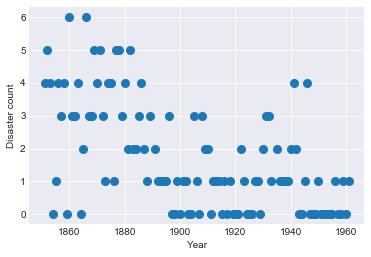

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
plt.style.use('seaborn-darkgrid')

# Initialize random number generator
np.random.seed(123)
%matplotlib inline 
disaster_data = np.ma.masked_values([4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                            3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                            2, 2, 3, 4, 2, 1, 3, -999, 2, 1, 1, 1, 1, 3, 0, 0,
                            1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                            0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                            3, 3, 1, -999, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                            0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1], value=-999)
year = np.arange(1851, 1962)

plt.plot(year, disaster_data, 'o', markersize=8);
plt.ylabel("Disaster count")
plt.xlabel("Year");

You can see here that most of the disasters are earlier in the time series - around mid- to late 19th century. 

Our question is *when did the safety regulation kick in* and there were probably numerous policy interventions. But we want to know when it all began to kick in. 

This could be 
- *when did our advertising campaign begin to kick in*
- *when did our new product launch begin to resonate with users*

Occurrences of disasters in the time series is thought to follow a Poisson process with a large rate parameter in the early part of the time series, and from one with a smaller rate in the later part. We are interested in locating the change point in the series, which perhaps is related to changes in mining safety regulations. 

In our model,

$$
\begin{aligned}
D_t &\sim \text{Pois}(r_t), r_t= \begin{cases}
l, & \text{if } t \lt s \\ 
e, & \text{if } t \ge s 
\end{cases} \\ 
s &\sim \text{Unif}(t_l, t_h)\\
e &\sim \text{exp}(1)\\
l &\sim \text{exp}(1)
\end{aligned}
$$

the parameters are defined as follows:
* $D_t$: The number of disasters in year $t$,
* $r_t$: The rate parameter of the Poisson distribution of disasters in year $t$. 
* $s$: The year in which the rate parameter changes (the switchpoint).
* $e$: The rate parameter before the switchpoint $s$.
* $l$: The rate parameter after the switchpoint $s$.
* $t_l$, $t_h$: The lower and upper boundaries of year $t$. 

This model is built much like our previous models. The major differences are the introduction of discrete variables with the Poisson and discrete-uniform priors and the novel form of the deterministic random variable `rate`.

![img](http://docs.pymc.io/api/distributions/discrete-5.hires.png)
Poisson log-likelihood.

Often used to model the number of events occurring in a fixed period of time when the times at which events occur are independent. The pmf ([probability mass function](https://en.wikipedia.org/wiki/Probability_mass_function)) of this distribution is

$f(x∣μ)=\dfrac{e^{-\mu} μ^{x}}{{x!}}$

In [3]:
with pm.Model() as disaster_model:

    switchpoint = pm.DiscreteUniform('switchpoint', lower=year.min(), upper=year.max(), testval=1900)

    # Priors for pre- and post-switch rates number of disasters
    early_rate = pm.Exponential('early_rate', 1)
    late_rate = pm.Exponential('late_rate', 1)

    # Allocate appropriate Poisson rates to years before and after current
    rate = pm.math.switch(switchpoint >= year, early_rate, late_rate)

    disasters = pm.Poisson('disasters', rate, observed=disaster_data)

The logic for `rate` is implemented here
* `rate = switch(switchpoint >= year, early_rate, late_rate)`

is implemented using `switch`, a Theano function that works like an if statement. It uses the first argument to switch between the next two arguments.

Missing values are handled transparently by passing a `MaskedArray` or a `pandas.DataFrame` with NaN values to the observed argument when creating an observed stochastic random variable. Behind the scenes, another random variable, `disasters.missing_values` is created to model the missing values. All we need to do to handle the missing values is ensure we sample this random variable as well.

Unfortunately because they are discrete variables and thus have no meaningful gradient, we cannot use `NUTS` (No U-Turn Sampler) for sampling switchpoint or the missing disaster observations. Instead, we will sample using a `Metroplis` step method, which implements adaptive `Metropolis-Hastings`, because it is designed to handle discrete values. PyMC3 automatically assigns the correct sampling algorithms. This is one of the best features of `PyMC3` the ability to abstract away these choices from you. 

Briefly - the NUTS is considered best in class, it's often the most accurate. It doesn't work for discrete problems though and we have to use an older and less-efficient sampler called Metropolis-Hastings. We'll talk about this in more depth, but briefly NUTS is more likely to give less-biased results. 

In [4]:
with disaster_model:
    trace = pm.sample(10000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [disasters_missing]
>>Metropolis: [switchpoint]
>NUTS: [late_rate, early_rate]
 38%|███▊      | 3956/10500 [00:05<00:08, 729.37it/s]INFO (theano.gof.compilelock): Waiting for existing lock by process '3204' (I am process '3205')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/peadarcoyle/.theano/compiledir_Darwin-17.4.0-x86_64-i386-64bit-i386-3.6.4-64/lock_dir
 38%|███▊      | 4042/10500 [00:05<00:08, 729.89it/s]INFO (theano.gof.compilelock): Waiting for existing lock by process '3204' (I am process '3206')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/peadarcoyle/.theano/compiledir_Darwin-17.4.0-x86_64-i386-64bit-i386-3.6.4-64/lock_dir
 82%|████████▏ | 8583/10500 [00:11<00:02, 752.94it/s]INFO (theano.gof.compilelock): Waiting for existing lock by process '3205' (I am process '3206')
INFO (theano.gof.compilelock): To manually release the lock, dele

In the trace plot below we can see that there’s about a 10 year span that’s plausible for a significant change in safety, but a 5 year span that contains most of the probability mass. The distribution is jagged because of the jumpy relationship between the year switchpoint and the likelihood and not due to sampling error.



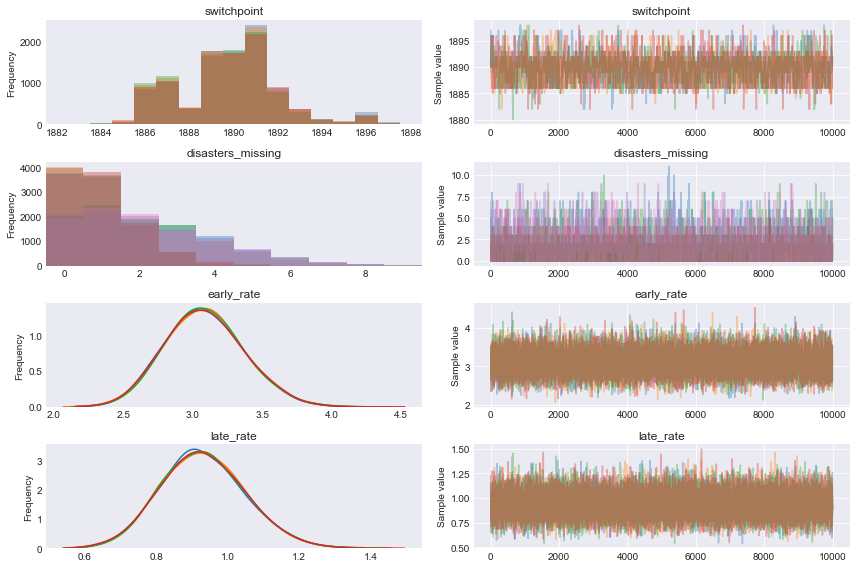

In [5]:
pm.traceplot(trace);


## 2. Results 
We can see above that there's a 5 year span that's most likely for the safety regulation changes. Between about 1888 and 1893. 

In your marketing example you may have several days or months - with some uncertainty over them. 

Hopefully that gives you a nice introduction to **Bayesian Changepoint detection** in **PyMC3**

**References**
- R.G. Jarrett. A note on the intervals between coal mining disasters. Biometrika, 66:191–193, 1979.